In [221]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [222]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["xai_api_key"]=os.getenv("X_AI")


In [223]:
from langchain_groq import ChatGroq
from langchain_xai import ChatXAI
from langchain_openai import ChatOpenAI

llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatXAI(model="grok-2")
#llm=ChatOpenAI(model="gpt-4o")

In [224]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph,END
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing_extensions import TypedDict

In [ ]:
#OpenSource llm for code reviewer 
#Grog for reviewer
#llm=ChatGroq(model="qwen-2.5-32b")

In [ ]:
class State(TypedDict, total=False):
    Objective_of_Code: str
    Code: str
    Agent_UserInstruction: str
    Objective_Check: str
    # Code_Standard_Checker: str
    # Code_Optimizer: str
    Feedback_Generator: str
    Summary: str
    # Code_Generator: str
    # Review_Report_Generator_Node: str

In [238]:
def get_user_input(state: State):
    Objective_of_Code = input("Please enter the Objective of the code to be reviewed: ")
    Agent_UserInstruction = input("What Types of Code Reviews you want the Agent to perform, can choose mulitple option (e.g., Syntax,Formatting,Code Quality,Security,Optimization,Best Practices & Design Pattern etc. ): ")
    Code = input("Please enter the code that needs to be reviewed: ")
    # print("Objective: ", ObjectiveCode_UserInstruction)
    # print("Agent Task: ", Agent_UserInstruction)
    # print("Code: ", Code_Issue_Identifier)
    return {"Objective_of_Code": Objective_of_Code, "Agent_UserInstruction": Agent_UserInstruction, "Code": Code}

In [239]:
def Objective_checker(state: State):
    """ Validate the Objective and the intend (Logic) of the code matches """
    Objective = state["Objective_of_Code"]
    Code = state["Code"]
    msg = llm.invoke(
        f"Validate if '{Objective}' and the intend (Logic) of the {Code} Matches. "
        f"Respond ONLY with 'True' (if intend Matches fully or Partially) or 'False' (if it is not Matching). Do not include any extra words."
    )
    is_valid = msg.content.strip().lower() == "true"
    return {"Objective_Check": is_valid}

In [255]:
def route_input(state: State):
    """
    Route the input to the appropriate tool based on the input status"""

    if state["Objective_Check"] == True:
        print("Accepted")
        return "Accepted"
    elif state["Objective_Check"] == False:
        print("Rejected")
        return "Rejected"

In [256]:
def Code_review(state: State):
    """ Review teh code based on the input by user"""
    Code = state["Code"]
    Agent_Task = state["Agent_UserInstruction"]
    review = llm.invoke(
        f'Based on the Type of Code Reviewer mentioned in {Agent_Task} review the code {Code} provide the feedback very briefly and concisely:'
        f'You should perform only the Type of Code Review mentioned in {Agent_Task} :'
        f'example if user request to perform "Syntax" reviewer in {Agent_Task} - Check for Syntax and provide the feedback accordinly :'
        f'example if user request to perform "Code Quality" reviewer in {Agent_Task} - check for Code Quality  and provide the feedback accordinly :'
                        )
    return {"Feedback_Generator": review.content}

In [257]:
def Summary_Generator(state: State):
    Objective = state["Objective_of_Code"]
    Code = state["Code"]
    Agent_Task = state["Agent_UserInstruction"]
    Feedback = state["Feedback_Generator"]
    Objective_Check = state["Objective_Check"]
    
    
    msg = llm.invoke(
        f"your task is to summarize the feedback provided by code reviewer,based on {Objective_Check} status and {Feedback} feedback "
        f"if the {Objective_Check} is False then provide the feedback as 'Code intend in {Code} and Objective in {Objective} is not matched' "
        f"if the {Objective_Check} is True then provide the feedback based on {Feedback} "
        f"Be specific, brief and highlight only the mistakes when required, display the Objective {Objective} , and what was asked you to perforam {Agent_Task} and your Summary"
    )
    return {"Summary": msg.content}

In [258]:
# Graph
Codebuilder = StateGraph(State)

In [259]:
Codebuilder.add_node("get_user_input",get_user_input)
Codebuilder.add_node("Objective_checker",Objective_checker)
Codebuilder.add_node("Code_review",Code_review)
Codebuilder.add_node("Summary_Generator",Summary_Generator)


Codebuilder.add_edge(START, "get_user_input")
Codebuilder.add_edge("get_user_input", "Objective_checker")
#Codebuilder.add_edge("get_user_input","Code_review")
Codebuilder.add_edge("Code_review","Summary_Generator")
Codebuilder.add_edge("Summary_Generator", END)

Codebuilder.add_conditional_edges(
    "Objective_checker",
    route_input,
    {
        "Accepted": "Code_review",
        "Rejected": "Summary_Generator"
    }
)

graph = Codebuilder.compile()

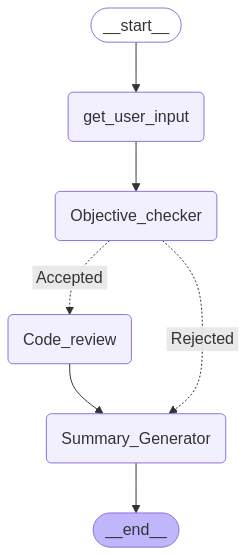

In [260]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [267]:
state = graph.invoke({"ObjectiveCode_UserInstruction": "","Code": "","Agent_UserInstruction": "","Feedback_Generator": "", "Summary": "","Objective_Check": ""}) 

Accepted


In [268]:
state

{'Objective_of_Code': 'Create the table',
 'Code': 'CREATE TL users (     id INT PRIMARY KEY,     username VARCHAR(50) NOT NULL,     email VARCHAR(100) UNIQUE NOT NULL,     password_hash TEXT NOT NULL,     created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP',
 'Agent_UserInstruction': 'Syntax',
 'Objective_Check': True,
 'Feedback_Generator': '**Syntax Review Feedback:**\n\n- Missing closing parenthesis `)` after `DEFAULT CURRENT_TIMESTAMP`.\n- Consider adding a comma after `DEFAULT CURRENT_TIMESTAMP`.\n\nCorrected query:\n```sql\nCREATE TABLE TL_users (\n    id INT PRIMARY KEY,\n    username VARCHAR(50) NOT NULL,\n    email VARCHAR(100) UNIQUE NOT NULL,\n    password_hash TEXT NOT NULL,\n    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP\n);\n```',
 'Summary': '**Objective:** Create the table\n\n**Task Performed:** Syntax Review\n\n**Summary:**\n- **Mistakes Identified:**\n  - Missing closing parenthesis `)` after `DEFAULT CURRENT_TIMESTAMP`.\n  - Consider adding a comma after `DEFAULT CUR

In [269]:
from IPython.display import Markdown
Markdown(state ['Summary'])

**Objective:** Create the table

**Task Performed:** Syntax Review

**Summary:**
- **Mistakes Identified:**
  - Missing closing parenthesis `)` after `DEFAULT CURRENT_TIMESTAMP`.
  - Consider adding a comma after `DEFAULT CURRENT_TIMESTAMP`.

- **Corrected Query:**
  ```sql
  CREATE TABLE TL_users (
      id INT PRIMARY KEY,
      username VARCHAR(50) NOT NULL,
      email VARCHAR(100) UNIQUE NOT NULL,
      password_hash TEXT NOT NULL,
      created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
  );
  ```